In [1]:
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')

Some functions for plotting. You don't have to understand how any
of the functions in this cell work, since they use things we 
haven't learned about in Data 8.

In [2]:
def resize_window(lim=3.5):
    plots.xlim(-lim, lim)
    plots.ylim(-lim, lim)
    
def draw_line(slope=0, intercept=0, x=make_array(-4, 4), color='#1e90ff'):
    y = x*slope + intercept
    plots.plot(x, y, color=color, lw=3)
    
def draw_vertical_line(x_position, color='black'):
    x = make_array(x_position, x_position)
    y = make_array(-4, 4)
    plots.plot(x, y, color=color, lw=3)
    
def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y

def r_scatter(r):
    """Generate a scatter plot with a correlation approximately r"""
    plots.figure(figsize=(5,5))
    x, y = make_correlated_data(r)
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

# Lecture 23

In [3]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

In [4]:
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

### Where is the prediction line?

**r = 0.99**

In [5]:
example = r_table(0.99)
example.show(3)

x,y
0.0912047,-0.0680119
1.09128,1.04391
-1.94697,-1.88316


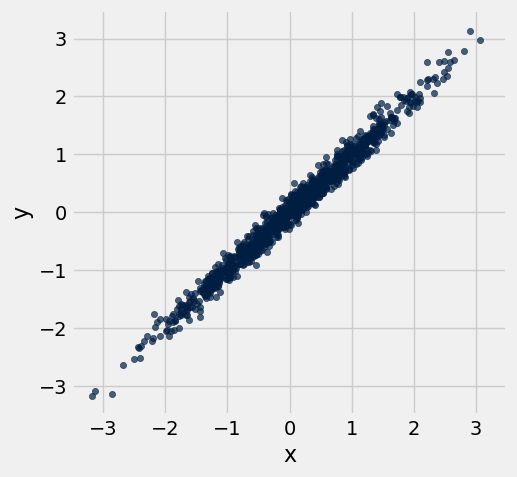

In [6]:
example.scatter('x', 'y')
resize_window()

**Nearest Neighbor regression method**

In [7]:
def nn_prediction_example(x_val):
    """ Predicts y-value for x based on the example table """
    neighbors = example.where('x', are.between(x_val - .25, x_val + .25))
    return np.mean(neighbors.column('y'))  

In [8]:
nn_prediction_example(-2.25)

-2.1476337989800527

In [9]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

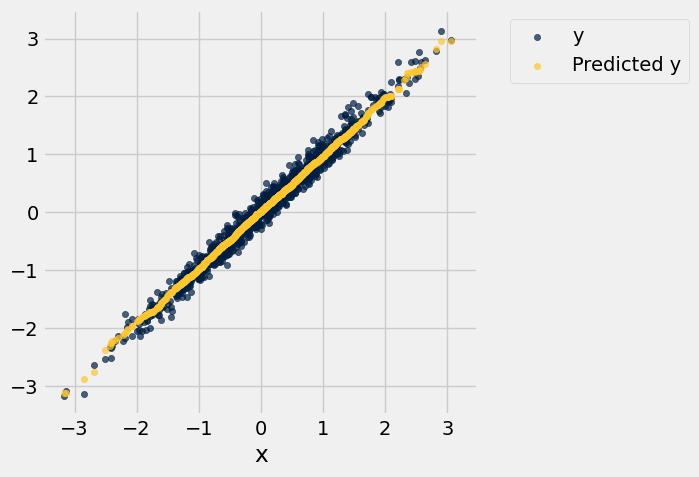

In [10]:
example.scatter('x')
resize_window()

One more step: draw the 45 degree line.

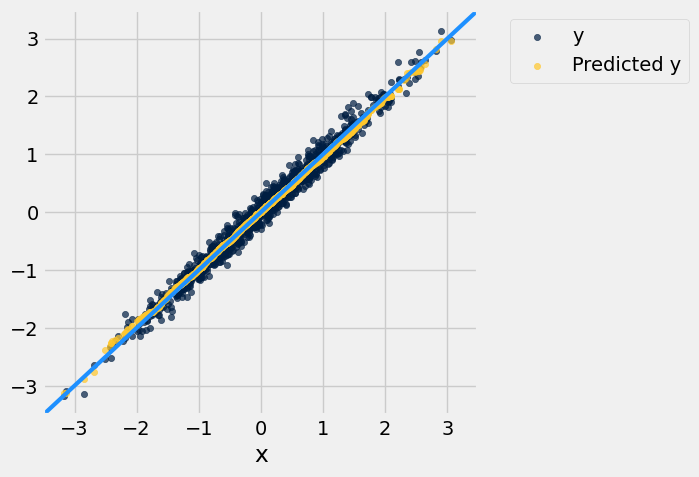

In [11]:
example.scatter('x')
draw_line(slope=1)
resize_window()

**r = 0**

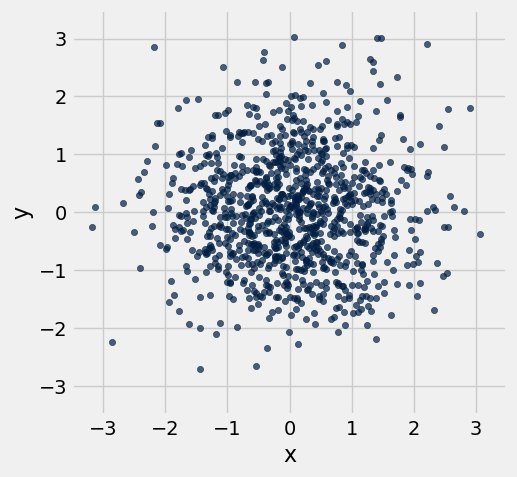

In [12]:
example = r_table(0)
example.scatter('x', 'y')
resize_window()

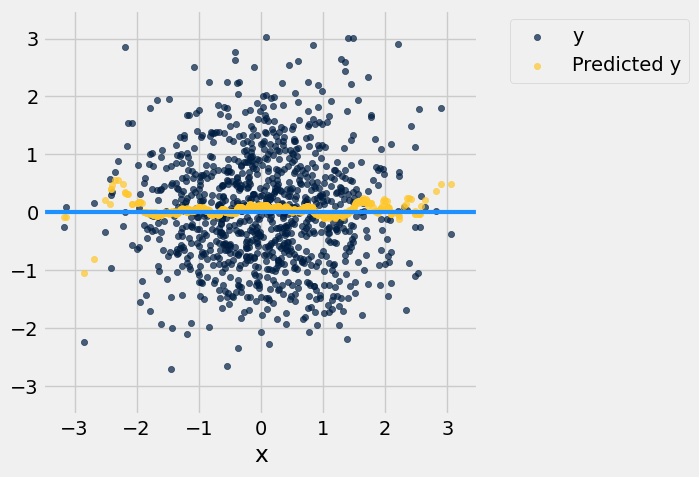

In [13]:
example = example.with_columns(
    'Predicted y', 
    example.apply(nn_prediction_example, 'x'))

example.scatter('x')
draw_line(slope = 0)
resize_window()

**r = 0.5**

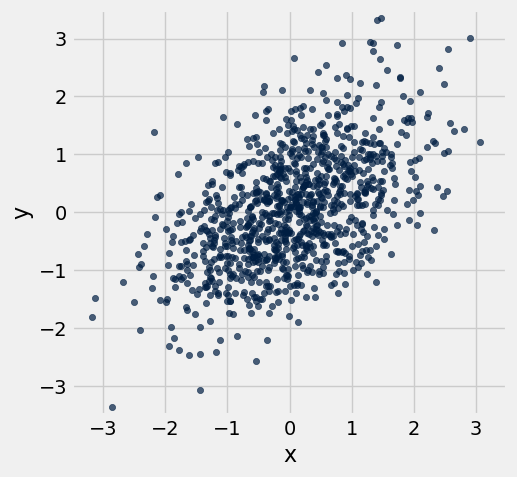

In [14]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()

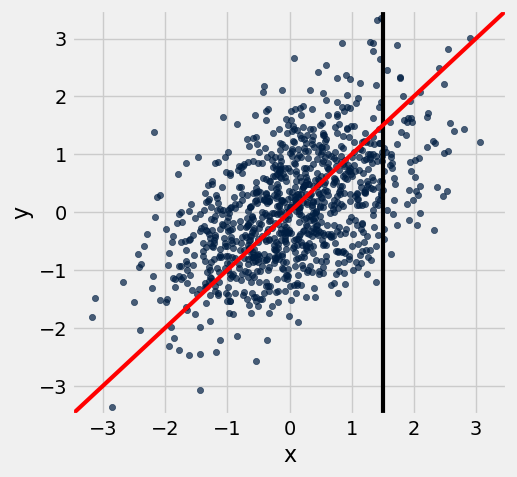

In [15]:
example = r_table(0.5)
example.scatter('x', 'y')
resize_window()
draw_vertical_line(1.5)
draw_line(slope=1, intercept=0, color='red')

The 45 degree line is "too high".

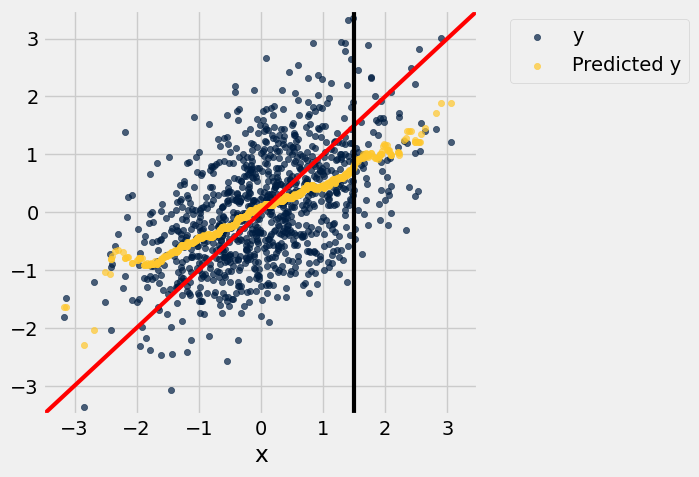

In [16]:
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=1, color='red')
draw_vertical_line(1.5)
resize_window()

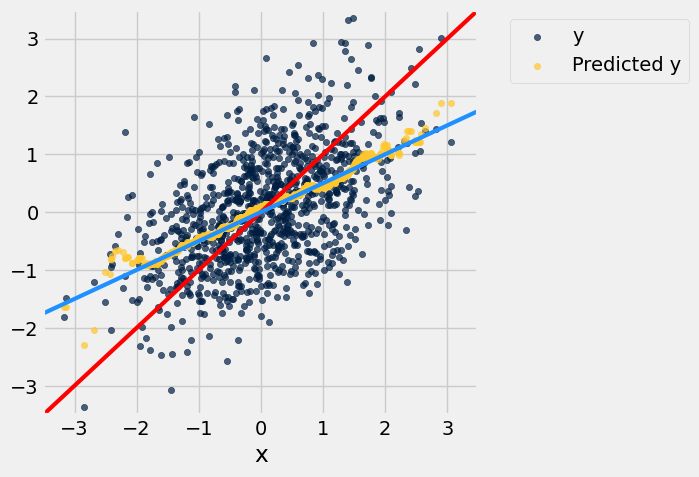

In [17]:
example.scatter('x')
draw_line(slope=1, intercept=0, color='red')
draw_line(slope=0.5, intercept=0)
resize_window()

**r = 0.7**

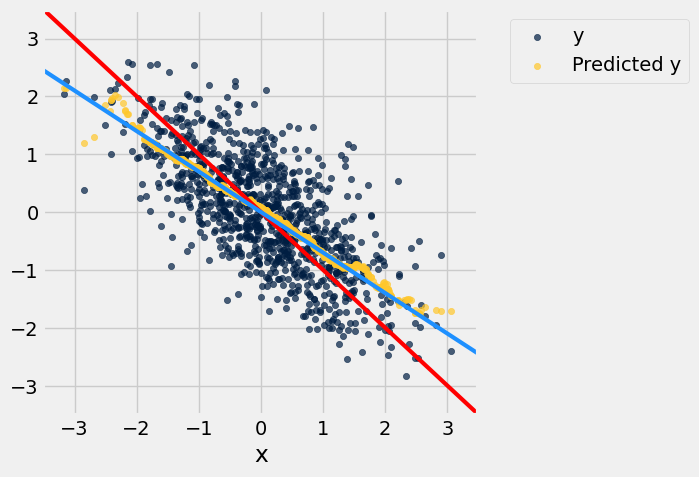

In [19]:
example = r_table(-0.7)
example = example.with_column('Predicted y', example.apply(nn_prediction_example, 'x'))
example.scatter('x')
draw_line(slope=-1, intercept=0, color='red')
draw_line(slope=-0.7, intercept=0, color='dodgerblue')
resize_window()

### Linear Regression

In [21]:
def slope(t, x, y):
    """Computes the slope of the regression line"""
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

In [22]:
def intercept(t, x, y):
    """Computes the intercept of the regression line"""
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

In [23]:
example = r_table(0.5)
slope(example, 'x', 'y')

0.50226382816259152

**Example: `heights` data**

In [24]:
families = Table.read_table('family_heights.csv')
families.show(5)

family,father,mother,child,children,order,sex
1,78.5,67,73.2,4,1,male
1,78.5,67,69.2,4,2,female
1,78.5,67,69,4,3,female
1,78.5,67,69,4,4,female
2,75.5,66.5,73.5,4,1,male


We wished to predict the average height of a *grown up child* based on the average height of their parents.

In [25]:
parent_avgs = (families.column('father') + families.column('mother'))/2
heights = Table().with_columns(
    'Parent Average', parent_avgs,
    'Child', families.column('child'),
)
heights.show(5)

Parent Average,Child
72.75,73.2
72.75,69.2
72.75,69
72.75,69
71,73.5


In [26]:
def nn_prediction_height(p_avg):
    """Predict the height of a child whose parents have a parent average height of p_avg.
    
    The prediction is the average height of the children whose parent average height is
    in the range p_avg plus or minus 0.5.
    """
    
    close_points = heights.where('Parent Average', are.between(p_avg-0.5, p_avg + 0.5))
    return np.average(close_points.column('Child')) 

In [27]:
heights_with_predictions = heights.with_column(
    'Nearest neighbor prediction', 
    heights.apply(nn_prediction_height, 'Parent Average'))
heights_with_predictions.show(5)

Parent Average,Child,Nearest neighbor prediction
72.75,73.2,70.1
72.75,69.2,70.1
72.75,69,70.1
72.75,69,70.1
71,73.5,70.4158


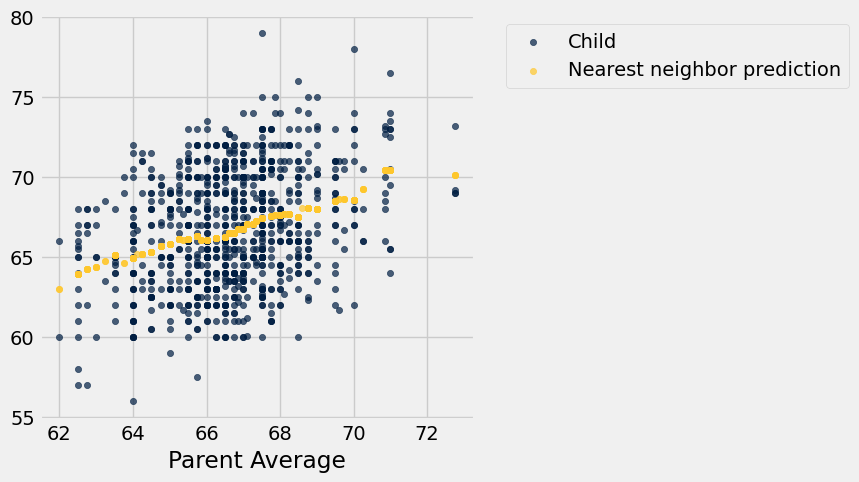

In [28]:
heights_with_predictions.scatter('Parent Average')

In [30]:
predicted_heights_slope = slope(heights, 'Parent Average', 'Child')
predicted_heights_intercept = intercept(heights, 'Parent Average', 'Child')
[predicted_heights_slope, predicted_heights_intercept]

[0.66449526235258838, 22.461839955758798]

In [31]:
heights_with_predictions = heights_with_predictions.with_column(
    'Regression Prediction', 
    predicted_heights_slope*heights.column('Parent Average') + predicted_heights_intercept
)
heights_with_predictions.show(5)

Parent Average,Child,Nearest neighbor prediction,Regression Prediction
72.75,73.2,70.1,70.8039
72.75,69.2,70.1,70.8039
72.75,69,70.1,70.8039
72.75,69,70.1,70.8039
71,73.5,70.4158,69.641


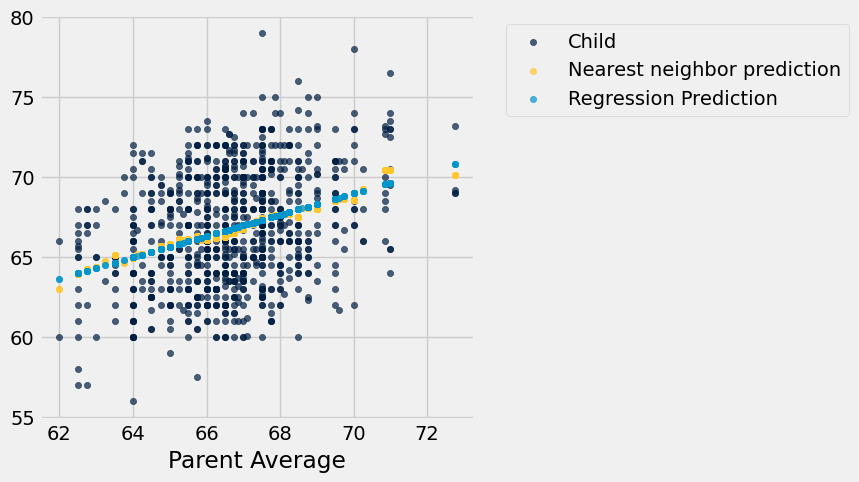

In [36]:
heights_with_predictions.scatter('Parent Average')

### Discussion Question

In [33]:
# X-axis: midterm scores
midterm_mean = 70
midterm_sd = 10

# Y-axis: final scores
final_mean = 50
final_sd = 12

# Correlation (relates X to Y values)
corr = 0.75

# X value
midterm_student = 90

In [34]:
midterm_student_su = (midterm_student - midterm_mean) / midterm_sd
midterm_student_su

2.0

In [35]:
final_student_su = midterm_student_su * corr

final_student_su

1.5

In [37]:
final_student_su = (final_student - final_mean) / final_sd
final_student = final_student_su * final_sd + final_mean
final_student

68.0

In [41]:
midterm_student_su = final_student_su * corr
midterm_student_su

1.125

In [43]:
midterm_student = midterm_student_su * midterm_sd + midterm_mean
midterm_student

81.25